In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import random

# Data Preparation

### Create dataset

In [13]:
# Create datasets

no_dementia_image_paths = os.listdir('/Users/aatyanth/COGS181/data_multiclass_classification/No_Dementia')
mild_dementia_image_paths = os.listdir('/Users/aatyanth/COGS181/data_multiclass_classification/Mild_Dementia')
advanced_dementia_image_paths = os.listdir('/Users/aatyanth/COGS181/data_multiclass_classification/Advanced_Dementia')

patient_ids = []
class_labels = []
image_paths = []
tracker = 0


prefix = '/data_multiclass_classification/Advanced_Dementia/'

for path in advanced_dementia_image_paths:
    patient_id = path.split('_')[1]
    if patient_id not in patient_ids:
        patient_subset = [path for path in advanced_dementia_image_paths if path.split('_')[1] == patient_id]
        chosen = random.sample(patient_subset, k=25)
        tracker += 1
        if tracker > 22:
            break
        for p in chosen:
            image_paths.append(prefix + p)
        for i in range(25):
            patient_ids.append(patient_id)
            class_labels.append(2)
    else:
        continue
    

prefix = '/data_multiclass_classification/Mild_Dementia/'
tracker = 0
for path in mild_dementia_image_paths:
    patient_id = path.split('_')[1]
    if patient_id not in patient_ids:
        patient_subset = [path for path in mild_dementia_image_paths if path.split('_')[1] == patient_id]
        chosen = random.sample(patient_subset, k=25)
        tracker += 1
        if tracker > 22:
            break
        for p in chosen:
            image_paths.append(prefix + p)
        for i in range(25):
            patient_ids.append(patient_id)
            class_labels.append(1)
    else:
        continue
    
prefix = '/data_multiclass_classification/No_Dementia/'
tracker = 0

for path in no_dementia_image_paths:
    patient_id = path.split('_')[1]
    if patient_id not in patient_ids:
        patient_subset = [path for path in no_dementia_image_paths if path.split('_')[1] == patient_id]
        chosen = random.sample(patient_subset, k=25)
        tracker += 1
        if tracker > 22:
            break
        for p in chosen:
            image_paths.append(prefix + p)
        for i in range(25):
            patient_ids.append(patient_id)
            class_labels.append(0)
    else:
        continue

In [14]:
df = pd.DataFrame([patient_ids, image_paths, class_labels]).transpose()
df.columns = ['patient_id', 'image_path', 'class_label']
df

,patient_id,image_path,class_label
0,0308,/data_multiclass_classification/Advanced_Demen...,2
1,0308,/data_multiclass_classification/Advanced_Demen...,2
2,0308,/data_multiclass_classification/Advanced_Demen...,2
3,0308,/data_multiclass_classification/Advanced_Demen...,2
4,0308,/data_multiclass_classification/Advanced_Demen...,2
...,...,...,...
1645,0346,/data_multiclass_classification/No_Dementia/OA...,0
1646,0346,/data_multiclass_classification/No_Dementia/OA...,0
1647,0346,/data_multiclass_classification/No_Dementia/OA...,0
1648,0346,/data_multiclass_classification/No_Dementia/OA...,0


### Train-Test Split (based on random selection of patients done in data_exploration.ipynb)

In [15]:
random.seed(62)
# Create separate dataframes for each class
class_0_df = df[df['class_label'].isin([0])]
class_1_df = df[df['class_label'].isin([1])]
class_2_df = df[df['class_label'].isin([2])]

train_choices_0 = random.sample(class_0_df['patient_id'].unique().tolist(), k=15)
train_choices_1 = random.sample(class_1_df['patient_id'].unique().tolist(), k=15)
train_choices_2 = random.sample(class_2_df['patient_id'].unique().tolist(), k=16)

test_choices_0 = []
for id in class_0_df['patient_id'].unique():
    if (id not in train_choices_0) and (id not in test_choices_0):
        test_choices_0.append(id)
    else:
        continue
test_choices_1 = []
for id in class_1_df['patient_id'].unique():
    if (id not in train_choices_1) and (id not in test_choices_1):
        test_choices_1.append(id)
    else:
        continue
test_choices_2 = []
for id in class_2_df['patient_id'].unique():
    if (id not in train_choices_2) and (id not in test_choices_2):
        test_choices_2.append(id)
    else:
        continue

print("Patient IDs for training set from class 0: ", train_choices_0)
print("Patient IDs for training set from class 1: ", train_choices_1)
print("Patient IDs for training set from class 2: ", train_choices_2)
print()
print("Patient IDs for testing set from class 0: ", test_choices_0)
print("Patient IDs for testing set from class 1: ", test_choices_1)
print("Patient IDs for testing set from class 2: ", test_choices_2)
print()

#Check that train and test sets have no overlapping participants
compare_0 = np.intersect1d(np.array(train_choices_0), np.array(test_choices_0))
if len(compare_0) > 0:
    print('INTERSECTING PATIENT ID\'S')
else:
    print("No intersecting ID\'s")
    
compare_1 = np.intersect1d(np.array(train_choices_1), np.array(test_choices_1))
if len(compare_1) > 0:
    print('INTERSECTING PATIENT ID\'S')
else:
    print("No intersecting ID\'s")

compare_2 = np.intersect1d(np.array(train_choices_2), np.array(test_choices_2))
if len(compare_2) > 0:
    print('INTERSECTING PATIENT ID\'S')
else:
    print("No intersecting ID\'s")
print()

# Create the training set dataframe
train_df = df[df['patient_id'].isin(train_choices_0 + train_choices_1 + train_choices_2)]
train_df = train_df.reset_index()
print("Number of participants in training set: ", int(len(train_df) / 16))

# Create the testing set dataframe
test_df = df[df['patient_id'].isin(test_choices_0 + test_choices_1 + test_choices_2)]
test_df = test_df.reset_index()
print("Number of participants in testing set: ", int(len(test_df) / 16))

print('Train Ratio: ', (len(train_df) / len(df)))
print('Test Ratio: ', (len(test_df) / len(df)))

Patient IDs for training set from class 0:  ['0214', '0055', '0234', '0229', '0026', '0096', '0356', '0213', '0322', '0369', '0275', '0349', '0132', '0050', '0317']
Patient IDs for training set from class 1:  ['0023', '0263', '0243', '0267', '0098', '0042', '0179', '0161', '0240', '0298', '0233', '0339', '0120', '0003', '0307']
Patient IDs for training set from class 2:  ['0031', '0028', '0053', '0035', '0073', '0056', '0308', '0278', '0134', '0122', '0223', '0316', '0291', '0185', '0268', '0351']

Patient IDs for testing set from class 0:  ['0182', '0144', '0146', '0141', '0068', '0330', '0346']
Patient IDs for testing set from class 1:  ['0286', '0115', '0380', '0084', '0287', '0022', '0039']
Patient IDs for testing set from class 2:  ['0137', '0382', '0052', '0373', '0269', '0067']

No intersecting ID's
No intersecting ID's
No intersecting ID's

Number of participants in training set:  71
Number of participants in testing set:  31
Train Ratio:  0.696969696969697
Test Ratio:  0.30303

# Data Pipeline

### Defining Transforms

In [16]:
# Importing the custom dataset class
from alzheimers_dataset import alzheimers_dataset
import torchvision.transforms as tf

In [17]:
# Simple transforms for baseline model
transforms = tf.Compose([
    tf.Pad([0, 124,]),
    tf.ToTensor(),
    ])

In [18]:
# Create datasets based on custom dataset class
root_dir = '/Users/aatyanth/COGS181'

train_image_paths = train_df['image_path'].to_numpy()
train_labels = train_df['class_label'].to_numpy()
train_set = alzheimers_dataset(root_dir=root_dir, image_paths=train_image_paths, labels=train_labels, transform=transforms)
test_image_paths = test_df['image_path'].to_numpy()
test_labels = test_df['class_label'].to_numpy()
test_set = alzheimers_dataset(root_dir=root_dir, image_paths=test_image_paths, labels=test_labels, transform=transforms)

# Set up DataLoaders for train and test set
train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=True, num_workers=2, drop_last=True)

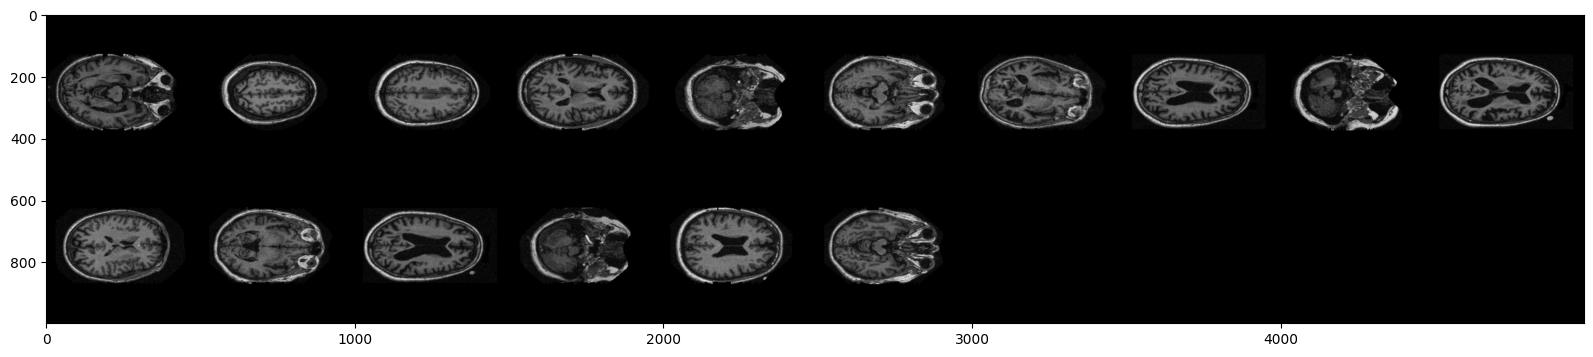

Mild Alzheimers   No Alzheimers   No Alzheimers   Mild Alzheimers   No Alzheimers   Mild Alzheimers   Advanced Alzheimers   Advanced Alzheimers   Advanced Alzheimers   Advanced Alzheimers


In [19]:
# Test how the images look

# Function to show image
def show_image(img):
    img = img.numpy()
    plt.figure(figsize=(20, 4))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

iteration = iter(train_loader)
images, labels = next(iteration)

show_image(torchvision.utils.make_grid(images, nrow=10))
classes = ("No Alzheimers", "Mild Alzheimers", "Advanced Alzheimers")
print("   ".join('%5s' % classes[labels[j]] for j in range(10)))


# Model Implementation

### Implement AlzheimersNet Class

In [20]:
class AlzheimersNet(nn.Module):
    
    def __init__(self):
        super(AlzheimersNet, self).__init__()
        
        # Initializing Convolution Blocks
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(num_features=16)
        self.pool = nn.AvgPool2d(kernel_size=3, stride=3)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(num_features=32)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.bn4 = nn.BatchNorm2d(num_features=128)
        
        
        # Initializing Linear Layers
        self.fc1 = nn.Linear(in_features=(128*6*6), out_features=512)
        self.dropout = nn.Dropout()
        
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 3)
    
    def forward(self, x):
        
        # implement the convolution blocks
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        
        # Flatten the layers
        flattened = torch.flatten(x, start_dim=1)
        # implement the fully connected network
        x = F.relu(self.fc1(flattened))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        
        # Store the output of the FCN
        output = F.relu(self.fc4(x))
        
        return output

# Training Implementation

In [21]:
# Choose the device
device = torch.device("cuda0" if torch.cuda.is_available() else "cpu")

# Create an instance of the Network
cnn = AlzheimersNet()

# Loss and optimizer to use
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.01, momentum=0.9)

# Moving network parameters to the chosen device
cnn.to(device)

AlzheimersNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): AvgPool2d(kernel_size=3, stride=3, padding=0)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4608, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, o

In [22]:
from tqdm import tqdm
# Training Procedure

avg_losses = []
epochs = 20
print_freq = 10
predictions_list = []

for epoch in tqdm(range(epochs), desc="Training Completion"):
    running_loss = 0.0
    for batch, data in enumerate(train_loader, 0):
        
        inputs, labels = data
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zeroing the gradients
        optimizer.zero_grad()
        
        # Generate predictions
        outputs = cnn(inputs)
        
        # Compute loss based on predictions and ground truth
        loss = loss_func(outputs, labels)
        
        # Take backwards step
        loss.backward()
        
        # Update the network parameters
        optimizer.step()
        
        running_loss += loss.item()
        
        if batch % print_freq == print_freq - 1:
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, batch, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Training Complete.')

Training Completion:   0%|          | 0/20 [00:00<?, ?it/s]

[epoch: 0, i:     9] avg mini-batch loss: 1.098
[epoch: 0, i:    19] avg mini-batch loss: 1.094
[epoch: 0, i:    29] avg mini-batch loss: 1.078
[epoch: 0, i:    39] avg mini-batch loss: 1.033
[epoch: 0, i:    49] avg mini-batch loss: 1.023
[epoch: 0, i:    59] avg mini-batch loss: 0.950
[epoch: 0, i:    69] avg mini-batch loss: 0.984


Training Completion:   5%|▌         | 1/20 [01:10<22:14, 70.23s/it]

[epoch: 1, i:     9] avg mini-batch loss: 1.008
[epoch: 1, i:    19] avg mini-batch loss: 1.028
[epoch: 1, i:    29] avg mini-batch loss: 1.027
[epoch: 1, i:    39] avg mini-batch loss: 0.940
[epoch: 1, i:    49] avg mini-batch loss: 0.941
[epoch: 1, i:    59] avg mini-batch loss: 0.996
[epoch: 1, i:    69] avg mini-batch loss: 1.061


Training Completion:  10%|█         | 2/20 [02:27<22:19, 74.39s/it]

[epoch: 2, i:     9] avg mini-batch loss: 1.052
[epoch: 2, i:    19] avg mini-batch loss: 0.952
[epoch: 2, i:    29] avg mini-batch loss: 0.921
[epoch: 2, i:    39] avg mini-batch loss: 0.912
[epoch: 2, i:    49] avg mini-batch loss: 0.947
[epoch: 2, i:    59] avg mini-batch loss: 0.944
[epoch: 2, i:    69] avg mini-batch loss: 0.899


Training Completion:  15%|█▌        | 3/20 [03:46<21:41, 76.57s/it]

[epoch: 3, i:     9] avg mini-batch loss: 0.815
[epoch: 3, i:    19] avg mini-batch loss: 0.834
[epoch: 3, i:    29] avg mini-batch loss: 0.930
[epoch: 3, i:    39] avg mini-batch loss: 0.891
[epoch: 3, i:    49] avg mini-batch loss: 0.968
[epoch: 3, i:    59] avg mini-batch loss: 0.968
[epoch: 3, i:    69] avg mini-batch loss: 0.900


Training Completion:  20%|██        | 4/20 [05:05<20:39, 77.48s/it]

[epoch: 4, i:     9] avg mini-batch loss: 0.936
[epoch: 4, i:    19] avg mini-batch loss: 0.948
[epoch: 4, i:    29] avg mini-batch loss: 0.830
[epoch: 4, i:    39] avg mini-batch loss: 0.773
[epoch: 4, i:    49] avg mini-batch loss: 0.821
[epoch: 4, i:    59] avg mini-batch loss: 0.705
[epoch: 4, i:    69] avg mini-batch loss: 0.823


Training Completion:  25%|██▌       | 5/20 [06:31<20:08, 80.60s/it]

[epoch: 5, i:     9] avg mini-batch loss: 0.882
[epoch: 5, i:    19] avg mini-batch loss: 0.789
[epoch: 5, i:    29] avg mini-batch loss: 0.702
[epoch: 5, i:    39] avg mini-batch loss: 0.717
[epoch: 5, i:    49] avg mini-batch loss: 0.637
[epoch: 5, i:    59] avg mini-batch loss: 0.603
[epoch: 5, i:    69] avg mini-batch loss: 0.636


Training Completion:  30%|███       | 6/20 [07:52<18:49, 80.70s/it]

[epoch: 6, i:     9] avg mini-batch loss: 0.551
[epoch: 6, i:    19] avg mini-batch loss: 0.547
[epoch: 6, i:    29] avg mini-batch loss: 0.650
[epoch: 6, i:    39] avg mini-batch loss: 0.736
[epoch: 6, i:    49] avg mini-batch loss: 0.601
[epoch: 6, i:    59] avg mini-batch loss: 0.519
[epoch: 6, i:    69] avg mini-batch loss: 0.540


Training Completion:  35%|███▌      | 7/20 [09:12<17:25, 80.43s/it]

[epoch: 7, i:     9] avg mini-batch loss: 0.646
[epoch: 7, i:    19] avg mini-batch loss: 0.574
[epoch: 7, i:    29] avg mini-batch loss: 0.439
[epoch: 7, i:    39] avg mini-batch loss: 0.639
[epoch: 7, i:    49] avg mini-batch loss: 0.530
[epoch: 7, i:    59] avg mini-batch loss: 0.424
[epoch: 7, i:    69] avg mini-batch loss: 0.516


Training Completion:  40%|████      | 8/20 [10:32<16:04, 80.38s/it]

[epoch: 8, i:     9] avg mini-batch loss: 0.649
[epoch: 8, i:    19] avg mini-batch loss: 0.569
[epoch: 8, i:    29] avg mini-batch loss: 0.402
[epoch: 8, i:    39] avg mini-batch loss: 0.430
[epoch: 8, i:    49] avg mini-batch loss: 0.558
[epoch: 8, i:    59] avg mini-batch loss: 0.438
[epoch: 8, i:    69] avg mini-batch loss: 0.486


Training Completion:  45%|████▌     | 9/20 [11:51<14:39, 80.00s/it]

[epoch: 9, i:     9] avg mini-batch loss: 0.470
[epoch: 9, i:    19] avg mini-batch loss: 0.424
[epoch: 9, i:    29] avg mini-batch loss: 0.361
[epoch: 9, i:    39] avg mini-batch loss: 0.386
[epoch: 9, i:    49] avg mini-batch loss: 0.284
[epoch: 9, i:    59] avg mini-batch loss: 0.435
[epoch: 9, i:    69] avg mini-batch loss: 0.402


Training Completion:  50%|█████     | 10/20 [13:12<13:21, 80.19s/it]

[epoch: 10, i:     9] avg mini-batch loss: 0.293
[epoch: 10, i:    19] avg mini-batch loss: 0.281
[epoch: 10, i:    29] avg mini-batch loss: 0.513
[epoch: 10, i:    39] avg mini-batch loss: 0.418
[epoch: 10, i:    49] avg mini-batch loss: 0.426
[epoch: 10, i:    59] avg mini-batch loss: 0.343
[epoch: 10, i:    69] avg mini-batch loss: 0.460


Training Completion:  55%|█████▌    | 11/20 [14:35<12:08, 80.99s/it]

[epoch: 11, i:     9] avg mini-batch loss: 0.335
[epoch: 11, i:    19] avg mini-batch loss: 0.294
[epoch: 11, i:    29] avg mini-batch loss: 0.347
[epoch: 11, i:    39] avg mini-batch loss: 0.645
[epoch: 11, i:    49] avg mini-batch loss: 0.320
[epoch: 11, i:    59] avg mini-batch loss: 0.229
[epoch: 11, i:    69] avg mini-batch loss: 0.216


Training Completion:  60%|██████    | 12/20 [15:56<10:48, 81.04s/it]

[epoch: 12, i:     9] avg mini-batch loss: 0.271
[epoch: 12, i:    19] avg mini-batch loss: 0.290
[epoch: 12, i:    29] avg mini-batch loss: 0.314
[epoch: 12, i:    39] avg mini-batch loss: 0.286
[epoch: 12, i:    49] avg mini-batch loss: 0.253
[epoch: 12, i:    59] avg mini-batch loss: 0.240
[epoch: 12, i:    69] avg mini-batch loss: 0.218


Training Completion:  65%|██████▌   | 13/20 [17:14<09:21, 80.25s/it]

[epoch: 13, i:     9] avg mini-batch loss: 0.261
[epoch: 13, i:    19] avg mini-batch loss: 0.234
[epoch: 13, i:    29] avg mini-batch loss: 0.158
[epoch: 13, i:    39] avg mini-batch loss: 0.161
[epoch: 13, i:    49] avg mini-batch loss: 0.169
[epoch: 13, i:    59] avg mini-batch loss: 0.121
[epoch: 13, i:    69] avg mini-batch loss: 0.327


Training Completion:  70%|███████   | 14/20 [18:34<08:01, 80.18s/it]

[epoch: 14, i:     9] avg mini-batch loss: 0.213
[epoch: 14, i:    19] avg mini-batch loss: 0.338
[epoch: 14, i:    29] avg mini-batch loss: 0.250
[epoch: 14, i:    39] avg mini-batch loss: 0.175
[epoch: 14, i:    49] avg mini-batch loss: 0.135
[epoch: 14, i:    59] avg mini-batch loss: 0.103
[epoch: 14, i:    69] avg mini-batch loss: 0.218


Training Completion:  75%|███████▌  | 15/20 [19:55<06:41, 80.23s/it]

[epoch: 15, i:     9] avg mini-batch loss: 0.123
[epoch: 15, i:    19] avg mini-batch loss: 0.133
[epoch: 15, i:    29] avg mini-batch loss: 0.203
[epoch: 15, i:    39] avg mini-batch loss: 0.190
[epoch: 15, i:    49] avg mini-batch loss: 0.186
[epoch: 15, i:    59] avg mini-batch loss: 0.216
[epoch: 15, i:    69] avg mini-batch loss: 0.142


Training Completion:  80%|████████  | 16/20 [21:14<05:19, 79.91s/it]

[epoch: 16, i:     9] avg mini-batch loss: 0.153
[epoch: 16, i:    19] avg mini-batch loss: 0.092
[epoch: 16, i:    29] avg mini-batch loss: 0.086
[epoch: 16, i:    39] avg mini-batch loss: 0.056
[epoch: 16, i:    49] avg mini-batch loss: 0.049
[epoch: 16, i:    59] avg mini-batch loss: 0.052
[epoch: 16, i:    69] avg mini-batch loss: 0.168


Training Completion:  85%|████████▌ | 17/20 [22:34<03:59, 79.93s/it]

[epoch: 17, i:     9] avg mini-batch loss: 0.318
[epoch: 17, i:    19] avg mini-batch loss: 0.110
[epoch: 17, i:    29] avg mini-batch loss: 0.115
[epoch: 17, i:    39] avg mini-batch loss: 0.049
[epoch: 17, i:    49] avg mini-batch loss: 0.202
[epoch: 17, i:    59] avg mini-batch loss: 0.151
[epoch: 17, i:    69] avg mini-batch loss: 0.054


Training Completion:  90%|█████████ | 18/20 [23:55<02:40, 80.15s/it]

[epoch: 18, i:     9] avg mini-batch loss: 0.033
[epoch: 18, i:    19] avg mini-batch loss: 0.020
[epoch: 18, i:    29] avg mini-batch loss: 0.034
[epoch: 18, i:    39] avg mini-batch loss: 0.019
[epoch: 18, i:    49] avg mini-batch loss: 0.097
[epoch: 18, i:    59] avg mini-batch loss: 0.105
[epoch: 18, i:    69] avg mini-batch loss: 0.170


Training Completion:  95%|█████████▌| 19/20 [25:14<01:20, 80.02s/it]

[epoch: 19, i:     9] avg mini-batch loss: 0.136
[epoch: 19, i:    19] avg mini-batch loss: 0.210
[epoch: 19, i:    29] avg mini-batch loss: 0.162
[epoch: 19, i:    39] avg mini-batch loss: 0.143
[epoch: 19, i:    49] avg mini-batch loss: 0.109
[epoch: 19, i:    59] avg mini-batch loss: 0.036
[epoch: 19, i:    69] avg mini-batch loss: 0.089


Training Completion: 100%|██████████| 20/20 [26:36<00:00, 79.84s/it]

Training Complete.


### Training Loss Curve

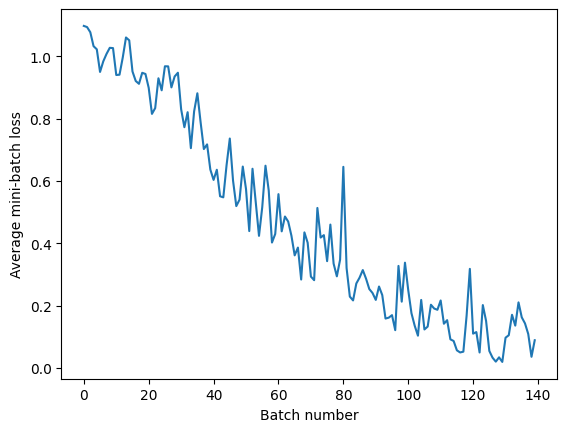

In [23]:
plt.plot(avg_losses)
plt.xlabel("Batch number")
plt.ylabel("Average mini-batch loss")
plt.show()

# Evaluation

In [24]:
# Test Accuracy

total_samples = 0
correct_predictions = 0

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = cnn(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total_samples += labels.size(0)
        
        correct_predictions += (predicted == labels).sum().item()
        
        

print("Accuracy of the Network on Test Data: ", (100 * (correct_predictions/total_samples)))

Accuracy of the Network on Test Data:  46.37096774193548


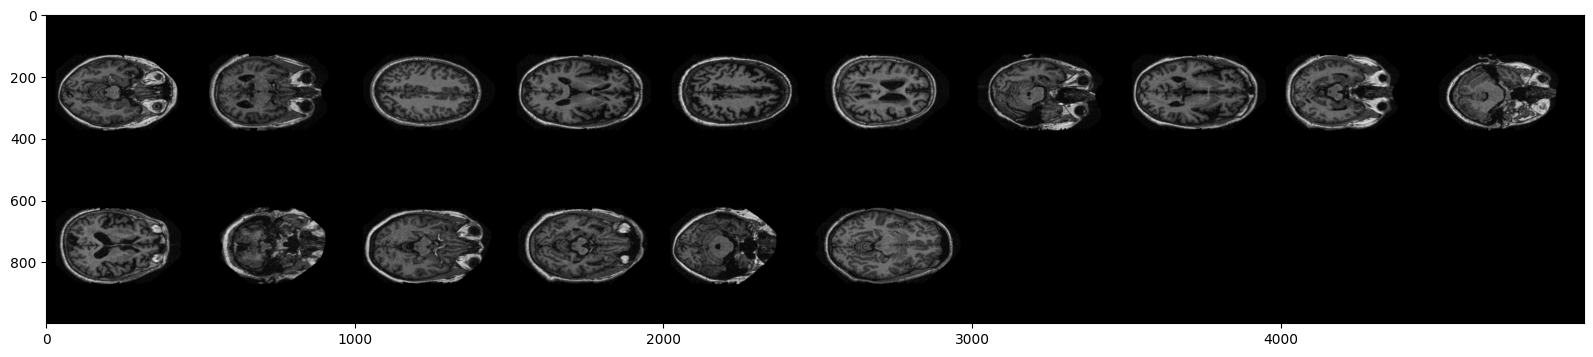

Predictions:   Advanced Alzheimers Advanced Alzheimers No Alzheimers Advanced Alzheimers Advanced Alzheimers Mild Alzheimers Mild Alzheimers Advanced Alzheimers Mild Alzheimers No Alzheimers
Ground Truth:  No Alzheimers Mild Alzheimers No Alzheimers Advanced Alzheimers Advanced Alzheimers Advanced Alzheimers Mild Alzheimers Advanced Alzheimers Mild Alzheimers Mild Alzheimers


In [25]:
# Visualize a few predictions
iteration = iter(test_loader)
images, labels = next(iteration)
images, labels = next(iteration)
show_image(torchvision.utils.make_grid(images, nrow=10))
outputs = cnn(images.to(device))
_, predictions = torch.max(outputs.data, 1)
classes = ("No Alzheimers", "Mild Alzheimers", "Advanced Alzheimers")
print("Predictions:  ", " ".join('%5s' % classes[predictions[i]] for i in range(10)))
print("Ground Truth: ", " ".join('%5s' % classes[labels[j]] for j in range(10)))

In [26]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(3))
class_total = list(0. for i in range(3))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = cnn(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(3):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of No Alzheimers : 46 %
Accuracy of Mild Alzheimers : 38 %
Accuracy of Advanced Alzheimers : 61 %
